# Generating plots for BDP report

In [1]:
import pandas as pd
import os
import csv
import subprocess # Can activate conda env from within script --> ask federica
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
# !pip install sklearn

In [3]:
# #centos@main:~/BDP-projcect-aws-main/condor_out$ grep "Duration" *
# train0.out:Duration 100
# train1.out:Duration 154
# train2.out:Duration 204
# train3.out:Duration 268
# train4.out:Duration 336
# train5.out:Duration 383

In [4]:
!cat ~/condor_job_duration

100
154
204
268
336
383



In [5]:
df = pd.read_csv('/Users/ila/condor_job_duration', delimiter="\n", header=None)

#  Adding custom columns:
duration_df = pd.DataFrame(df.values, columns=['seconds'])
duration_df

,seconds
0,100
1,154
2,204
3,268
4,336
5,383


In [6]:
average_time = duration_df.seconds.mean()
average_time

240.83333333333334

# DF for Memory usage per run

In [7]:
memory_df = pd.read_csv('/Users/ila/memory_run1', delimiter='\n', header=None)
memory_df = pd.DataFrame(memory_df.values, columns=['MB'])
memory_df['RAM MiB'] = memory_df.MB*0.9537
memory_df

,MB,RAM MiB
0,33,31.4721
1,54,51.4998
2,69,65.8053
3,84,80.1108
4,98,93.4626
5,117,111.5829


# Evaluating Time of Execution 

In [8]:
df_size = pd.read_csv('/Users/ila/input_size_condor_all', sep='\n', header=None)
df_bytes = pd.DataFrame(df_size.values, columns=['bytes'])
df_bytes

,bytes
0,15904983
1,5301661
2,10603322
3,15904983
4,21206644
5,26508305
6,31809966


In [9]:
# omitting line one: only the file for prediction - as it will remain constant
train_bytes_df = df_bytes.loc[1:6]
train_bytes_df = pd.DataFrame(train_bytes_df.values, index=[0,1,2,3,4,5], columns=['bytes'])
train_bytes_df

,bytes
0,5301661
1,10603322
2,15904983
3,21206644
4,26508305
5,31809966


In [10]:
bytes_time_df = train_bytes_df.join(duration_df)
bytes_time_df

,bytes,seconds
0,5301661,100
1,10603322,154
2,15904983,204
3,21206644,268
4,26508305,336
5,31809966,383


In [11]:
bytes_time_df['input MiB'] = bytes_time_df.bytes/(1024*1024)
bytes_time_df['minutes'] = bytes_time_df.seconds/60
bytes_time_df['days'] = bytes_time_df.seconds/8400

bytes_time_df = bytes_time_df.join(memory_df)

# Inputsize vs Memory usage

In [12]:
bytes_time_df


,bytes,seconds,input MiB,minutes,days,MB,RAM MiB
0,5301661,100,5.056058,1.666667,0.011905,33,31.4721
1,10603322,154,10.112116,2.566667,0.018333,54,51.4998
2,15904983,204,15.168174,3.400000,0.024286,69,65.8053
3,21206644,268,20.224232,4.466667,0.031905,84,80.1108
4,26508305,336,25.280290,5.600000,0.040000,98,93.4626
5,31809966,383,30.336348,6.383333,0.045595,117,111.5829


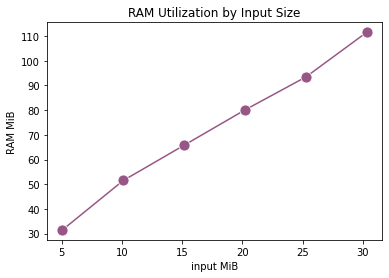

In [13]:
ax = sn.lineplot(data=bytes_time_df, x='input MiB', y='RAM MiB', markersize=11,
marker="o", color="#965786")
ax.set(title='RAM Utilization by Input Size')
fig1 = ax.get_figure()
# fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/ram_utilization_jobs.png')
# fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/ram_utilization_jobs.pdf')

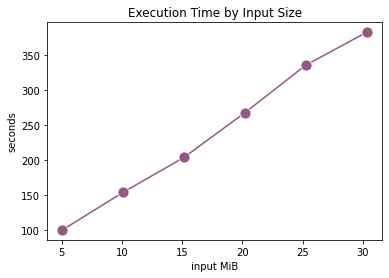

In [14]:
ax = sn.lineplot(data=bytes_time_df, x='input MiB', y='seconds', markersize=11,
marker="o", color="#965786")
ax.set(title='Execution Time by Input Size')
fig2 = ax.get_figure()
# fig2.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/execution_by_input_size.png')
# fig2.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/execution_by_input_size.pdf')

# Linear regression
## Prediction of time based on input size

In [15]:
data = bytes_time_df
X=data['input MiB'].values.reshape(-1,1)
Y=data['seconds'].values.reshape(-1,1)
linear_reg = sklearn.linear_model.LinearRegression().fit(X,Y)
Y_pred = linear_reg.predict(X)  # make predictions


In [16]:
X

array([[ 5.05605793],
       [10.11211586],
       [15.16817379],
       [20.22423172],
       [25.28028965],
       [30.33634758]])

In [17]:
Y_pred

array([[ 96.19047619],
       [154.04761905],
       [211.9047619 ],
       [269.76190476],
       [327.61904762],
       [385.47619048]])

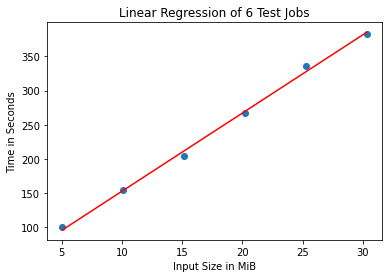

In [18]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
# Add title and axis names
plt.title('Linear Regression of 6 Test Jobs')
plt.xlabel('Input Size in MiB')
plt.ylabel('Time in Seconds')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_time.pdf')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_time.png')
plt.show()

In [19]:
# Appending value of a real input size that would be used to train a model in a real use case
X_real = X 
X_real = np.append(X_real,200).reshape(-1,1)
X_real

array([[  5.05605793],
       [ 10.11211586],
       [ 15.16817379],
       [ 20.22423172],
       [ 25.28028965],
       [ 30.33634758],
       [200.        ]])

In [20]:
Y_pred_real = linear_reg.predict(X_real)
Y_pred_real

array([[  96.19047619],
       [ 154.04761905],
       [ 211.9047619 ],
       [ 269.76190476],
       [ 327.61904762],
       [ 385.47619048],
       [2326.95991389]])

In [21]:
pwd

'/Users/ila/01_unibo/BDP-projcect-aws-main/stats'

In [22]:
minutes_for_200_mib_input = 2326.95991389/60

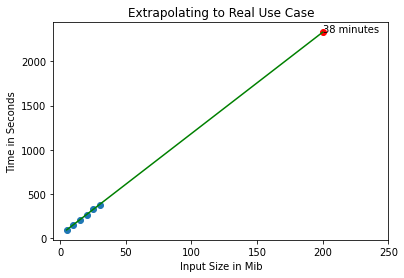

In [23]:
plt.scatter(X, Y)
plt.scatter(200., 2326.95991389, color='red')
# Add label to dot
plt.annotate("38 minutes", (200., 2326.95991389))
plt.plot(X_real, Y_pred_real, color='green') # Marking real use case in red

# Add title and axis names
plt.title('Extrapolating to Real Use Case')
plt.xlabel('Input Size in Mib')
plt.ylabel('Time in Seconds')

# To keep text withing limits of the axes
plt.xlim([-5,250])
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_time_label.pdf')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_time_label.png')
plt.show()

# Source confirms that SVM scale linearly
# https://www.researchgate.net/post/What-is-the-running-time-complexity-of-SVM-and-ANN 

Bottou, Léon, and Chih-Jen Lin. "Support vector machine solvers." Large scale kernel machines (2007): 301-320.

# Linear regression
## Prediction of RAM based on input size

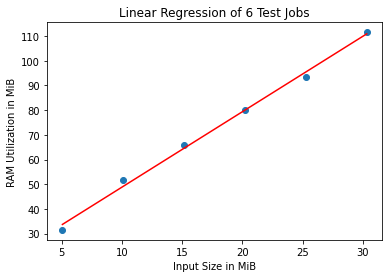

In [42]:
data = bytes_time_df
X=data['input MiB'].values.reshape(-1,1)
Y=data['RAM MiB'].values.reshape(-1,1)
linear_reg = sklearn.linear_model.LinearRegression().fit(X,Y)
Y_pred = linear_reg.predict(X)  # make predictions

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
# Add title and axis names
plt.title('Linear Regression of 6 Test Jobs')
plt.xlabel('Input Size in MiB')
plt.ylabel('RAM Utilization in MiB')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_ram.pdf')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_ram.png')
plt.show()



In [43]:
# Appending value of a real input size that would be used to train a model in a real use case
X_real = X 
X_real = np.append(X_real,200).reshape(-1,1)
X_real
Y_pred_real = linear_reg.predict(X_real)
Y_pred_real

array([[ 33.6974    ],
       [ 49.14734   ],
       [ 64.59728   ],
       [ 80.04722   ],
       [ 95.49716   ],
       [110.9471    ],
       [629.39314757]])

In [44]:
X_real

array([[  5.05605793],
       [ 10.11211586],
       [ 15.16817379],
       [ 20.22423172],
       [ 25.28028965],
       [ 30.33634758],
       [200.        ]])

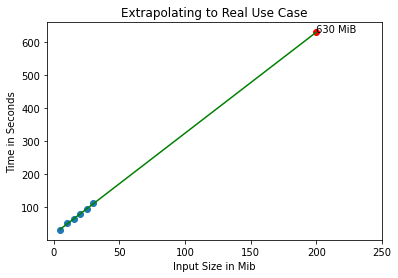

In [46]:
plt.scatter(X, Y)
plt.scatter(200., 629.39314757, color='red')
plt.annotate("630 MiB", (200., 629.39314757))
plt.plot(X_real, Y_pred_real, color='green') # Marking real use case in red
# Add title and axis names
plt.title('Extrapolating to Real Use Case')
plt.xlabel('Input Size in Mib')
plt.ylabel('Time in Seconds')
plt.xlim([-5,250])
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_ram_label.pdf')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_ram_label.png')
plt.show()

# Docker Duration

In [47]:
df2 = pd.read_csv('/Users/ila/condor_job_duration_docker', delimiter=" ", header=None)
docker_duration_df = pd.DataFrame(df2.values, columns=["seconds"])
docker_duration_df

,seconds
0,105
1,157
2,214
3,277
4,351
5,397


# Scaling up to gridsearch (10 combinations of C and gamma) crossvalidating producing 50 models

25 worker nodes a 2 vCPU plus one main node of the same make: 

26 nodes in the cluser

&rarr; 2 jobs per node! 
&rarr; run 50 in one go within 38 minutes provided there is no errors


In [48]:
# 2 vCPU in USD
# Hourly price for the cluster
t4g_medium = 0.0336*26 
print("26 t4g_medium Machienes ammounting to 50 CPU's cost", t4g_medium, 'USD per hour')

26 t4g_medium Machienes ammounting to 50 CPU's cost 0.8735999999999999 USD per hour


In [49]:
per_min_cost_cluster = t4g_medium/60

In [50]:
per_min_cost_cluster

0.014559999999999998

In [51]:
sec_cost_cluster = per_min_cost_cluster/60
sec_cost_cluster

0.00024266666666666664

Given an up time 38 minutes 

In [52]:
run_time_non_trivial = per_min_cost_cluster*38
run_time_non_trivial

0.5532799999999999

# This would ammount to a total spending of 0.5532 USD for a 38 min run on 25 wn plus 1 main

In [63]:
price_per_months_full_cluster = t4g_medium*24*30
price_per_months_full_cluster

628.992

In [54]:
st_sp = 50*153
print("The completion of the challeng requres only ", st_sp, "MB storage space.")

The completion of the challeng requres only  7650 MB storage space.


In [55]:
# 7650

In [57]:
bytes_time_df['cost'] = bytes_time_df.seconds*sec_cost_cluster

In [58]:
bytes_time_df

,bytes,seconds,input MiB,minutes,days,MB,RAM MiB,cost
0,5301661,100,5.056058,1.666667,0.011905,33,31.4721,0.024267
1,10603322,154,10.112116,2.566667,0.018333,54,51.4998,0.037371
2,15904983,204,15.168174,3.400000,0.024286,69,65.8053,0.049504
3,21206644,268,20.224232,4.466667,0.031905,84,80.1108,0.065035
4,26508305,336,25.280290,5.600000,0.040000,98,93.4626,0.081536
5,31809966,383,30.336348,6.383333,0.045595,117,111.5829,0.092941


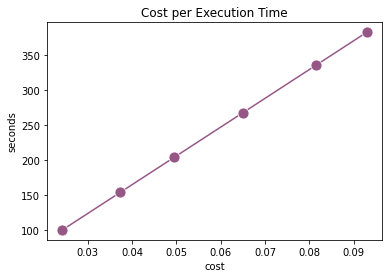

In [59]:
ax = sn.lineplot(data=bytes_time_df, x='cost', y='seconds', markersize=11,
marker="o", color="#965786")
ax.set(title='Cost per Execution Time')
fig2 = ax.get_figure()
# fig2.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/time_cost.png')
# fig2.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/time_cost.pdf')

In [60]:
# # pot run_time vs price
# data = bytes_time_df
# X=data['cost'].values.reshape(-1,1)
# Y=data['seconds'].values.reshape(-1,1)
# linear_reg = sklearn.linear_model.LinearRegression().fit(X,Y)
# Y_pred = linear_reg.predict(X)  # make predictions

# plt.scatter(X, Y)
# plt.plot(X, Y_pred, color='red')
# # Add title and axis names
# plt.title('Linear Regression of 6 Test Jobs')
# plt.xlabel('Cost')
# plt.ylabel('Time in Seconds')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/cost_time.pdf')
# # plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_time.png')
# plt.show()

In [61]:
df2 = bytes_time_df.seconds

In [95]:
df2

0    100
1    154
2    204
3    268
4    336
5    383
Name: seconds, dtype: int64

# Time vs cost vs number of machines **t4g_medium** used

In [107]:
# t_c_nm = pd.read_csv('./time_cost_machine.csv', sep=',')
# fixing typo
# t_c_nm['machines'] = t_c_nm['machienes']
# drop uneeded cols
# t_c_nm.drop(['cost per hour','hour per job', 'jobs pairs', 'jobs per machine', 'jobs', 'Unnamed: 7'], axis=1, inplace=True)

t_c_nm['tot machines'] = t_c_nm['main node'] + t_c_nm['worker nodes']
t_c_nm

,main node,worker nodes,cores per machine,jobs per core,total time Hrs,total cost wn $,total cost $,tot machines
0,1,1,2,25.000000,15.833332,5.282,10.563999,2
1,1,2,2,12.500000,7.916666,5.282,7.923000,3
2,1,3,2,8.333333,5.277778,5.282,7.042666,4
3,1,4,2,6.250000,3.958333,5.282,6.602500,5
4,1,5,2,5.000000,3.166666,5.282,6.338400,6
5,1,6,2,4.166667,2.638889,5.282,6.162333,7
6,1,7,2,3.571429,2.261905,5.282,6.036571,8
7,1,8,2,3.125000,1.979167,5.282,5.942250,9
8,1,9,2,2.777778,1.759259,5.282,5.868889,10
9,1,10,2,2.500000,1.583333,5.282,5.810200,11


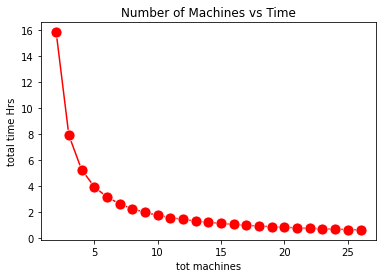

In [130]:
ax = sn.lineplot(data=t_c_nm, x='tot machines', y='total time Hrs', markersize=11, marker="o", color="red")
# ax.twinx()

ax.set(title='Number of Machines vs Time')
fig1 = ax.get_figure()
fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/n_machines_time.png')
# fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/n_machines_time.pdf')

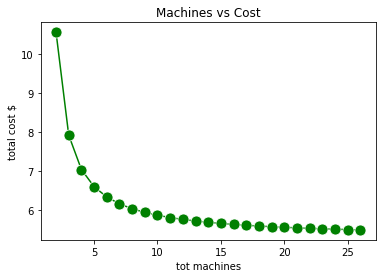

In [129]:
ax = sn.lineplot(data=t_c_nm, x='tot machines', y='total cost $', markersize=11,  marker="o", color="green")
ax.set(title='Machines vs Cost')
fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/n_machines_cost.png')
# fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/n_machines_cost.pdf')
fig1 = ax.get_figure()

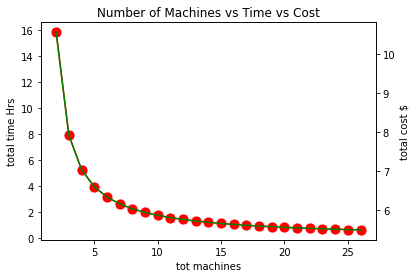

In [131]:
ax = sn.lineplot(data=t_c_nm, x='tot machines', y='total time Hrs', markersize=11, marker="o", color="red")
ax.twinx()
ax = sn.lineplot(data=t_c_nm, x='tot machines', y='total cost $', markersize=11, color="green")
ax.set(title='Number of Machines vs Time vs Cost')
fig1 = ax.get_figure()
fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/n_machines_time_cost.png')
# fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/n_machines_time_cost.pdf')

In [1]:
!pwd

/Users/ila/01_unibo/BDP-projcect-aws-main/stats


In [15]:
!grep "Duration" ../condor_out/* 

../condor_out/train0.out:Duration 100
../condor_out/train1.out:Duration 154
../condor_out/train2.out:Duration 204
../condor_out/train3.out:Duration 268
../condor_out/train4.out:Duration 336
../condor_out/train5.out:Duration 383


In [16]:
!grep "Duration" ../condor_out/* | awk '{print $NF}'

100
154
204
268
336
383


In [17]:
!grep "Duration" ../condor_out_docker/* | awk '{print $NF}'

105
157
214
277
351
397


In [10]:
# Runtime native in seconds
native= [100,
154,
204,
268,
336,
383]

In [23]:
# Runtime docker in seconds
docker = [105,
157,
214,
277,
351,
397]

In [34]:
x = []
for n in range(len(native)):
    x.append(docker[n]/native[n])

In [39]:
for i in x:
   print((i-1)*100)

5.000000000000004
1.9480519480519431
4.90196078431373
3.3582089552238736
4.464285714285721
3.6553524804177506


# Docker was between 1,9 % and 5.0 % slower

Container specs - see below:

In [4]:
!cat ../docker/DOCKERFILE

FROM centos:8
RUN yum install -y epel-release  
RUN yum install -y libsvm


In [ ]:
# Re ran with a libsvm ubuntu container:


In [ ]:
centos@main:~/BDP-projcect-aws-main$ grep "Duration" condor_out_docker2/*
condor_out_docker2/train0.out:Duration 97
condor_out_docker2/train1.out:Duration 149
condor_out_docker2/train2.out:Duration 214
condor_out_docker2/train3.out:Duration 272
condor_out_docker2/train4.out:Duration 338
condor_out_docker2/train5.out:Duration 385

In [6]:
!grep "Duration" ../condor_out_docker2/*

../condor_out_docker2/train0.out:Duration 97
../condor_out_docker2/train1.out:Duration 149
../condor_out_docker2/train2.out:Duration 214
../condor_out_docker2/train3.out:Duration 272
../condor_out_docker2/train4.out:Duration 338
../condor_out_docker2/train5.out:Duration 385


In [7]:
!grep "Duration" ../condor_out_docker2/* | awk '{print $NF}'

97
149
214
272
338
385


In [8]:
d_ubuntu = [97,
149,
214,
272,
338,
385]

In [12]:
x = []
for n in range(len(native)):
    x.append(d_ubuntu[n]/native[n])

for i in x:
   print((i-1)*100)

-3.0000000000000027
-3.2467532467532423
4.90196078431373
1.4925373134328401
0.5952380952380931
0.5221932114882533


### Ubuntu libsvm container faster for the first 2 files and was slower only for the last 4 input files...